# Kandisnky 2.1 Inpainting Pipeline
### 1. To replace the background of original image 
### 2. Mask the intended objects in a image you want to persist
### 3. Write a simple text prompt in whichever language comfortable describing how the background should look like
### 4. BAM!! Within 3 steps your new images with replaced background is ready

In [1]:
# !pip install diffusers transformers accelerate

In [2]:
from PIL import Image, ImageFilter
from diffusers import KandinskyV22InpaintPipeline, KandinskyV22PriorPipeline
from diffusers.utils import load_image
import torch
import numpy as np

### Loading the Prior and Decoder Models

In [3]:
kd_pipeline_prior = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16).to("cuda")
kd_pipeline = KandinskyV22InpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16).to("cuda")

kd_pipeline.enable_attention_slicing()
kd_pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

### Create text prompts, can understand 100+ languages 

In [14]:
prompt = "Célébrations du Vendredi Saint, Candles, dekoracja kwiatowa, photorealism"
negative_prompt = "low quality, schlechte Qualität, tekenfilm, animation, graphics"

image_embedding, zero_image_embedding = kd_pipeline_prior(prompt, negative_prompt, return_dict=False)

  0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
mask_blur = 18

# loading the original and masked image
orig_image = load_image("167.jpg").convert("RGB").resize((512, 512))
mask_image = load_image("167_mask.jpg").convert("L").resize((512, 512))

# converting pil image to numpy array for further processing
init_array = np.asarray(orig_image)
dummy_ones = np.ones((init_array.shape[0], init_array.shape[1]), dtype=np.float32)
mask = dummy_ones - np.asarray(mask_image)/255.

# creating blurred mask image using Gaussian Blur
mask_img = Image.fromarray(np.uint8(mask)*255).convert("L")
mask_blur_img = mask_img.filter(ImageFilter.GaussianBlur(mask_blur))

In [16]:
seed = 42

generated_images = kd_pipeline(image=orig_image,
                               mask_image=mask_blur_img,
                               image_embeds=image_embedding,
                               negative_image_embeds=zero_image_embedding,
                               height=512,
                               width=512,
                               num_inference_steps=50,
                               num_images_per_prompt=4,
                               generator = torch.Generator().manual_seed(seed)).images

  0%|          | 0/50 [00:00<?, ?it/s]

## Display Generated Images which have filled the background of original image according to the provided text prompts

In [8]:
from diffusers.utils import load_image
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

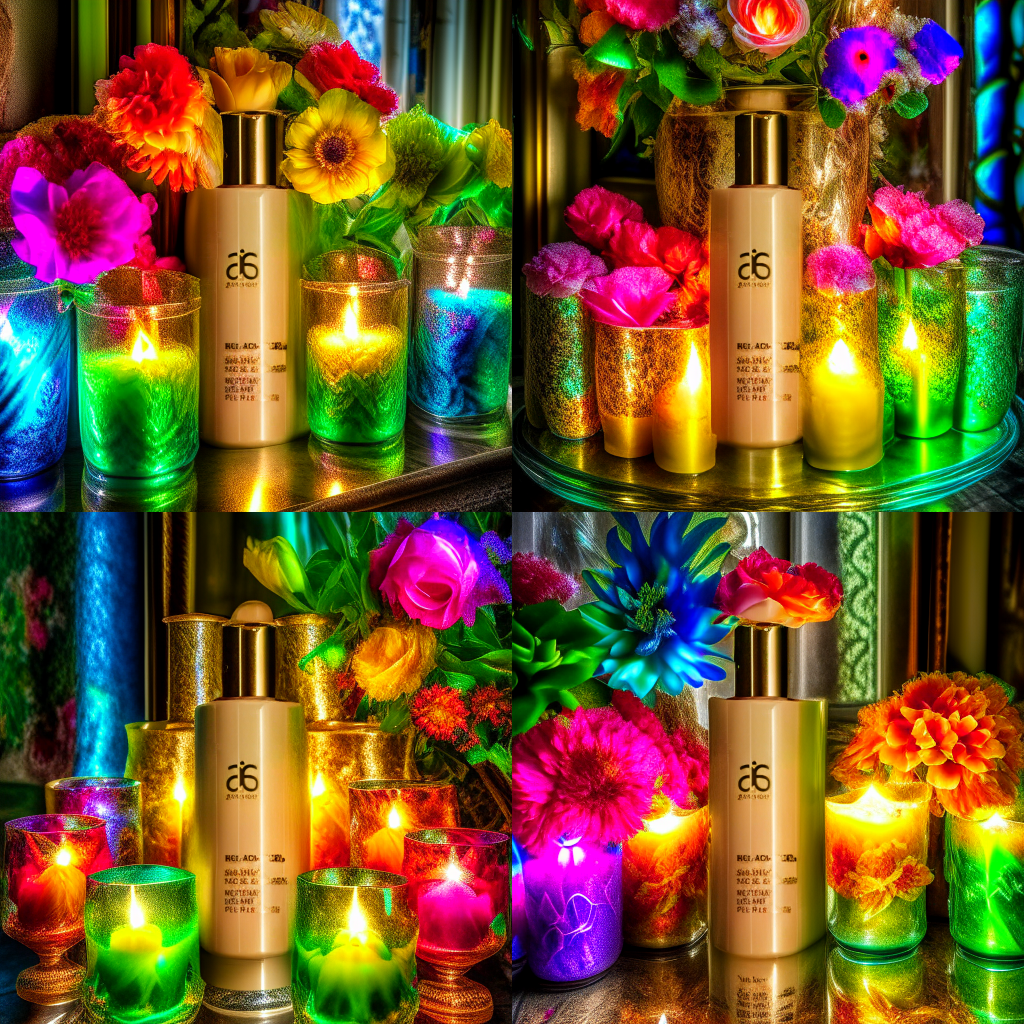

In [17]:
image_grid(generated_images, 2, 2)